In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from datetime import datetime

# Configure matplotlib for LaTeX rendering
plt.rcParams.update({
    'text.usetex': False,  # Disable LaTeX to use system fonts
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],  # Impact first, fallbacks
    'font.size': 20,
    'axes.labelsize': 25,
    'axes.titlesize': 25,
    'legend.fontsize': 25,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'figure.titlesize': 30,
    'pgf.rcfonts': False,  # Use LaTeX default fonts for PGF
    'pgf.preamble': r'\usepackage{amsmath}\usepackage{amsfonts}'
})

from plot.multicurve import MultiCurvePlotter
from plot.log_dual_plot import LogDualPlot

from core.nodes.transmission_node import TransmissionNode
from core.nodes.computing_node import ComputingNode

# Complete Offloading

- No computing on User Satellite in Offloading case
- Variation of $\phi_\text{ec}$
- Ratio $S_\text{isl} / S_\text{gl}$

In [2]:
with_legend = True
plot_precision = 1000

data_size = 100
phi_min = 0.0  # Minimum phi value
phi_max = 1.5  # Maximum phi value


In [3]:
config = {
    "base": {
        "obdh": {
            "speed": 30.0,
            "phi": 0.9,
            "energy_uptime": 1,
            "energy_io": 0.001
        },
        "ground_link": {
            "speed": 10.0,
            "energy": 5,
            "distance": 700
        }
    },
    "offloading": {
        "user_satellite": {
            "obdh": { # No computing on the user satellite in this scenario
                "phi": None,
                "speed": None,
                "energy_uptime": None,
                "energy_io": None
            },
            "isl": {
                "speed": None, # Exploring ISL speed variation
                "energy": 3,
                "distance": 100
            }
        },
        "edge_node": {
            "edge_computer": {
                "phi": None, # Exploring EC phi variation
                "speed": 300.0,
                "energy_uptime": 50,
                "energy_io": 0.001
            },
            "ground_link": {
                "speed": None, # Exploring GL speed variation
                "energy": 5,
                "distance": 700
            }
        }
    }
}

# Base Case

- Computing on User Satellite (OBDH)
- Ground Link

In [4]:
base_obdh_speed = config['base']['obdh']['speed']
base_odbh_phi = config['base']['obdh']['phi']
base_obdh_energy_uptime = config['base']['obdh']['energy_uptime']
base_obdh_energy_io = config['base']['obdh']['energy_io']

# Base Case - calculate reference costs
base_time_cost = 0
base_energy_cost = 0

obc = ComputingNode(
    speed=base_obdh_speed,
    phi=base_odbh_phi
)

base_time_cost += obc.time_cost(data_size)
base_energy_cost += obc.energy_cost(
    data_size,
    energy_uptime=base_obdh_energy_uptime,
    energy_io=base_obdh_energy_io
)

d_out_obc = obc.process(data_size)

base_ground_link_speed = config['base']['ground_link']['speed']
base_ground_link_energy = config['base']['ground_link']['energy']
base_ground_link_distance = config['base']['ground_link']['distance']

ground_link = TransmissionNode(
    speed=base_ground_link_speed
)

base_time_cost += ground_link.time_cost(d_out_obc)
base_energy_cost += ground_link.energy_cost(
    d_out_obc,
    energy=base_ground_link_energy,
    distance=base_ground_link_distance
)

print(f"Base case - Time: {base_time_cost:.3f}s, Energy: {base_energy_cost:.3f}J")

Base case - Time: 12.333s, Energy: 131.463J


In [5]:
n_satellites = range(1, 10, 1)
s_isl = base_ground_link_speed * 1.6
print(f"N satelites : {n_satellites}")
print(f"s_isl : {s_isl}")

N satelites : range(1, 10)
s_isl : 16.0


# Offloading Case

- No computing on User Satellite
- ISL to Edge Node
- Computing on Edge Node
- Edge Node ground link

In [6]:
time_costs = []
energy_costs = []

# Variation of Usr ISL
# isl_speed = config['offloading']['user_satellite']['isl']['speed']
off_isl_energy = config['offloading']['user_satellite']['isl']['energy']
off_isl_distance = config['offloading']['user_satellite']['isl']['distance']

off_edge_computer_speed = config['offloading']['edge_node']['edge_computer']['speed']
# Variation of EC phi
# edge_computer_phi = config['offloading']['edge_node']['edge_computer']['phi']
off_edge_computer_energy_uptime = config['offloading']['edge_node']['edge_computer']['energy_uptime']
off_edge_computer_energy_io = config['offloading']['edge_node']['edge_computer']['energy_io']

# Variation of EN gl
# off_ground_link_speed = config['offloading']['edge_node']['ground_link']['speed']
off_ground_link_energy = config['offloading']['edge_node']['ground_link']['energy']
off_ground_link_distance = config['offloading']['edge_node']['ground_link']['distance']

print("Computing cost grid...")

# ISL transmission
isl = TransmissionNode(speed=float(s_isl))
after_isl_iteration_time_cost = isl.time_cost(data_size)
after_isl_iteration_energy_cost = isl.energy_cost(
    data_size,
    energy=off_isl_energy,
    distance=off_isl_distance
)

d_out_isl = isl.process(data_size)

for i, n in enumerate(n_satellites):
    phi_en = (1/ (2 ** (1/n)))
    print(f"Satellite {n}...")

    edge_computer = ComputingNode(
    speed=off_edge_computer_speed,
    phi=phi_en
    )

    iteration_time_cost = after_isl_iteration_time_cost + edge_computer.time_cost(d_out_isl)
    iteration_energy_cost = after_isl_iteration_energy_cost + edge_computer.energy_cost(
        d_out_isl,
        energy_uptime=off_edge_computer_energy_uptime,
        energy_io=off_edge_computer_energy_io
    )

    d_out_ec = edge_computer.process(d_out_isl)

    if n > 1:
        for _ in range(n-1):
            en_isl = TransmissionNode(speed=float(s_isl))
            iteration_time_cost += en_isl.time_cost(d_out_ec)
            iteration_energy_cost += en_isl.energy_cost(
                d_out_ec,
                energy=off_isl_energy,
                distance=off_isl_distance
            )

            d_out_ec = en_isl.process(d_out_ec)

            edge_computer = ComputingNode(
            speed=off_edge_computer_speed,
            phi=phi_en
            )

            iteration_time_cost += edge_computer.time_cost(d_out_ec)
            iteration_energy_cost += edge_computer.energy_cost(
                d_out_ec,
                energy_uptime=off_edge_computer_energy_uptime,
                energy_io=off_edge_computer_energy_io
            )

            d_out_ec = edge_computer.process(d_out_ec)

    # Ground link transmission (fixed speed)
    ground_link = TransmissionNode(speed=float(base_ground_link_speed))
    iteration_time_cost += ground_link.time_cost(d_out_ec)
    iteration_energy_cost += ground_link.energy_cost(
        d_out_ec,
        energy=off_ground_link_energy,
        distance=off_ground_link_distance
    )

    print(d_out_ec)

    # Total costs
    time_costs.append(iteration_time_cost)
    energy_costs.append(iteration_energy_cost)

Computing cost grid...
Satellite 1...
50
Satellite 2...
49
Satellite 3...
49
Satellite 4...
48
Satellite 5...
48
Satellite 6...
48
Satellite 7...
48
Satellite 8...
47
Satellite 9...
47


[11.583333333333332, 16.091666666666665, 20.765833333333333, 25.339999999999996, 30.014166666666664, 34.75416666666666, 39.165, 43.6075, 48.215833333333336]
[125.39411766702308, 161.95823531368262, 200.48756864701596, 237.59435296034218, 276.1236862936755, 315.1956862936755, 351.55435296034216, 387.57580394033505, 425.56247060700167]


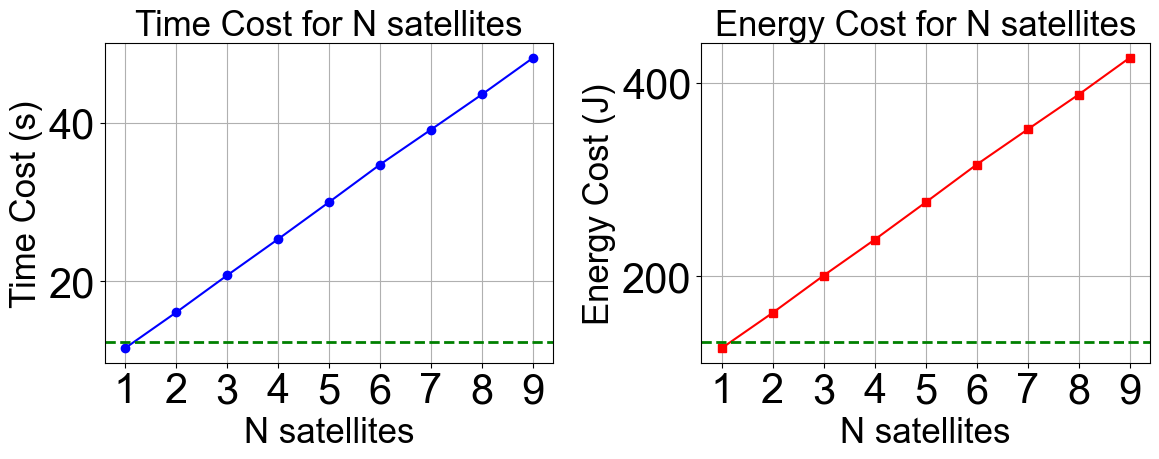

Results exported to script1_results.csv


In [7]:
print(time_costs)
print(energy_costs)

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First plot
ax1.plot(n_satellites, time_costs, marker='o', color='blue')
ax1.axhline(y=base_time_cost, color='green', linestyle='--', linewidth=2, label='Threshold')
ax1.set_xlabel('N satellites')
ax1.set_ylabel('Time Cost (s)')
ax1.set_title('Time Cost for N satellites')
ax1.set_xticks(n_satellites)
ax1.grid(True)

# Second plot
ax2.plot(n_satellites, energy_costs, marker='s', color='red')
ax2.axhline(y=base_energy_cost, color='green', linestyle='--', linewidth=2, label='Threshold')
ax2.set_xlabel('N satellites')
ax2.set_ylabel('Energy Cost (J)')
ax2.set_title('Energy Cost for N satellites')
ax2.set_xticks(n_satellites)
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

# Export results to CSV
df = pd.DataFrame({
    'n_satellites': n_satellites,
    'time_cost': time_costs,
    'energy_cost': energy_costs
})
df.to_csv('script1_results.csv', index=False)
print("Results exported to script1_results.csv")

Computing cost per satellite...
Processing Satellite 1...
Processing Satellite 2...
Processing Satellite 3...
Processing Satellite 4...
Processing Satellite 5...
Processing Satellite 6...
Processing Satellite 7...
Processing Satellite 8...
Processing Satellite 9...
Processing Satellite 10...

Final output data size: 47

Results exported to per_satellite_costs.csv


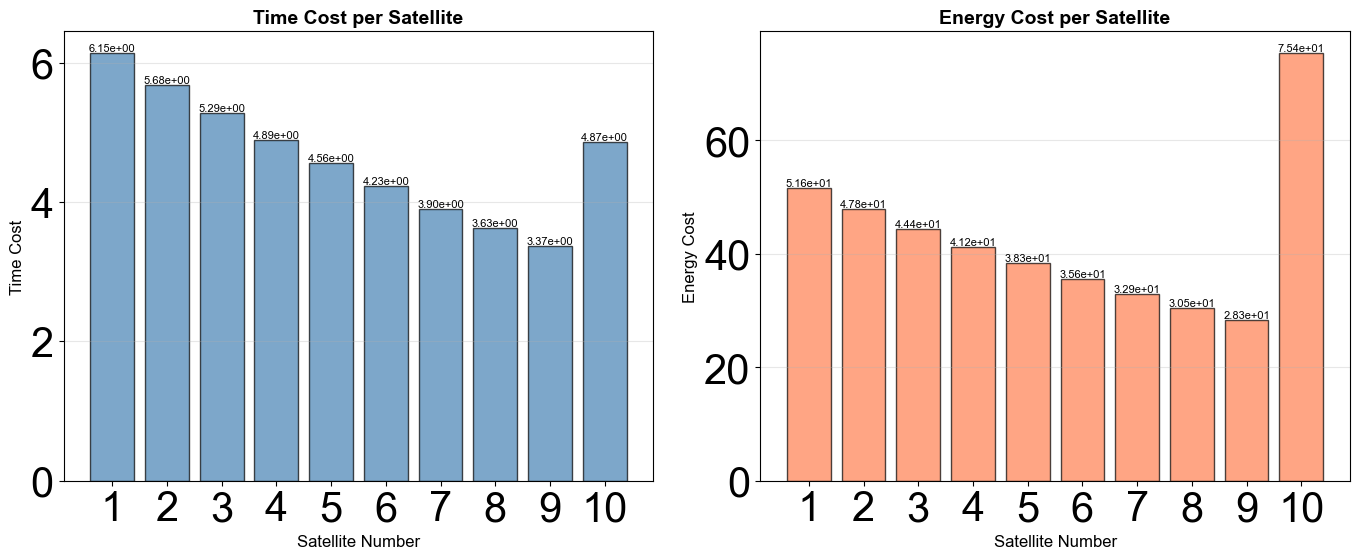


=== Per Satellite Cost Summary ===
Satellite 1: Time=6.1458e+00, Energy=5.1642e+01
Satellite 2: Time=5.6850e+00, Energy=4.7843e+01
Satellite 3: Time=5.2867e+00, Energy=4.4419e+01
Satellite 4: Time=4.8917e+00, Energy=4.1163e+01
Satellite 5: Time=4.5592e+00, Energy=3.8282e+01
Satellite 6: Time=4.2300e+00, Energy=3.5569e+01
Satellite 7: Time=3.9008e+00, Energy=3.2856e+01
Satellite 8: Time=3.6342e+00, Energy=3.0517e+01
Satellite 9: Time=3.3708e+00, Energy=2.8347e+01
Satellite 10: Time=4.8700e+00, Energy=7.5411e+01

Total Time Cost: 4.6574e+01
Total Energy Cost: 4.2605e+02


In [9]:
import matplotlib.pyplot as plt
import pandas as pd

n_satellites = 10
phi_en = (1 / (2 ** (1/n_satellites)))

# Store costs per satellite
satellite_time_costs = []
satellite_energy_costs = []
satellite_numbers = []

# Variation of Usr ISL
off_isl_energy = config['offloading']['user_satellite']['isl']['energy']
off_isl_distance = config['offloading']['user_satellite']['isl']['distance']

off_edge_computer_speed = config['offloading']['edge_node']['edge_computer']['speed']
off_edge_computer_energy_uptime = config['offloading']['edge_node']['edge_computer']['energy_uptime']
off_edge_computer_energy_io = config['offloading']['edge_node']['edge_computer']['energy_io']

off_ground_link_energy = config['offloading']['edge_node']['ground_link']['energy']
off_ground_link_distance = config['offloading']['edge_node']['ground_link']['distance']

print("Computing cost per satellite...")

d_out = data_size
isl_time_cost = 0
isl_energy_cost = 0

# Process each satellite (transmission + edge computer)
for sat_num in range(1, n_satellites + 1):
    print(f"Processing Satellite {sat_num}...")

    # Edge computer processing
    edge_computer = ComputingNode(
        speed=off_edge_computer_speed,
        phi=phi_en
    )

    ec_time_cost = edge_computer.time_cost(d_out)
    ec_energy_cost = edge_computer.energy_cost(
        d_out,
        energy_uptime=off_edge_computer_energy_uptime,
        energy_io=off_edge_computer_energy_io
    )

    d_out = edge_computer.process(d_out)

    # If not the last satellite, prepare ISL for next hop
    if sat_num < n_satellites:
        isl = TransmissionNode(speed=float(s_isl))
        isl_time_cost = isl.time_cost(d_out)
        isl_energy_cost = isl.energy_cost(
            d_out,
            energy=off_isl_energy,
            distance=off_isl_distance
        )
        d_out = isl.process(d_out)

        sat_time_cost = isl_time_cost + ec_time_cost
        sat_energy_cost = isl_energy_cost + ec_energy_cost

    else:
        sat_time_cost = ec_time_cost
        sat_energy_cost = ec_energy_cost

    satellite_numbers.append(sat_num)
    satellite_time_costs.append(sat_time_cost)
    satellite_energy_costs.append(sat_energy_cost)

# Add ground link cost to the last satellite
ground_link = TransmissionNode(speed=float(base_ground_link_speed))
gl_time_cost = ground_link.time_cost(d_out)
gl_energy_cost = ground_link.energy_cost(
    d_out,
    energy=off_ground_link_energy,
    distance=off_ground_link_distance
)

satellite_time_costs[-1] += gl_time_cost
satellite_energy_costs[-1] += gl_energy_cost

print(f"\nFinal output data size: {d_out}")

# Export to CSV
df = pd.DataFrame({
    'satellite_number': satellite_numbers,
    'time_cost': satellite_time_costs,
    'energy_cost': satellite_energy_costs
})
df.to_csv('per_satellite_costs.csv', index=False)
print("\nResults exported to per_satellite_costs.csv")

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Time Cost per Satellite
ax1.bar(satellite_numbers, satellite_time_costs, color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Satellite Number', fontsize=12)
ax1.set_ylabel('Time Cost', fontsize=12)
ax1.set_title('Time Cost per Satellite', fontsize=14, fontweight='bold')
ax1.set_xticks(satellite_numbers)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (sat, cost) in enumerate(zip(satellite_numbers, satellite_time_costs)):
    ax1.text(sat, cost, f'{cost:.2e}', ha='center', va='bottom', fontsize=8)

# Plot 2: Energy Cost per Satellite
ax2.bar(satellite_numbers, satellite_energy_costs, color='coral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Satellite Number', fontsize=12)
ax2.set_ylabel('Energy Cost', fontsize=12)
ax2.set_title('Energy Cost per Satellite', fontsize=14, fontweight='bold')
ax2.set_xticks(satellite_numbers)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (sat, cost) in enumerate(zip(satellite_numbers, satellite_energy_costs)):
    ax2.text(sat, cost, f'{cost:.2e}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('per_satellite_costs.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\n=== Per Satellite Cost Summary ===")
for sat, time_cost, energy_cost in zip(satellite_numbers, satellite_time_costs, satellite_energy_costs):
    print(f"Satellite {sat}: Time={time_cost:.4e}, Energy={energy_cost:.4e}")

print(f"\nTotal Time Cost: {sum(satellite_time_costs):.4e}")
print(f"Total Energy Cost: {sum(satellite_energy_costs):.4e}")